<font size='5'>Install dependencies</font>

In [76]:
%pip install -r requirements.txt -v

Using pip 25.1 from c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


<font size='5'>Import Libraries</font>

In [ ]:
# Core dependencies
import pandas as pd
import numpy as np

# NLP model
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

# Text pre-processing and cleaning
import string

import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print("Pandas:", pd.__version__)
print("NumPy:", np.__version__)
print("Spacy:", spacy.__version__)
print("ImbLearn:", imblearn.__version__)
print("Scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("✅ Libraries Loaded")


Pandas: 2.3.2
NumPy: 2.3.2
Spacy: 3.8.7
ImbLearn: 0.14.0
Scikit-learn: 1.7.1
Matplotlib: 3.10.5
Seaborn: 0.13.2
✅ Libraries Loaded


<font size='5'>Load Pre-trained SpaCy model</font>

In [78]:
nlp = spacy.load("en_core_web_sm")


<font size='5'>Gather Stop Words</font>

In [79]:
stopwords = STOP_WORDS
print(stopwords)
print(len(stopwords))

{'’ll', 'about', 'could', 'make', 'elsewhere', 'down', 'throughout', 'both', 'will', 'as', 'was', 'own', 'fifteen', "'ll", 'twenty', 'over', 'n‘t', 'even', 'be', 'does', 'ever', 'us', '‘ll', '‘d', 'whereupon', 'them', 'top', 'toward', 'her', 'go', 'between', 'whole', 'see', 'ourselves', 'i', 'already', 'on', 'so', 'onto', 'hereupon', 'less', 'anyway', 'besides', 'namely', 'please', 'via', 'amount', 'almost', 'often', 'another', 'n’t', 'formerly', 'some', 'nevertheless', 'upon', 'unless', 'regarding', 'seeming', 'into', 'within', 'always', 'hereby', 'because', 'side', 'they', 'nobody', 'show', 'alone', 'such', 'thereby', 'due', 'that', 'wherein', 'and', 'are', 'off', 'from', 'using', 'everyone', 'neither', 'however', 'when', 're', 'perhaps', 'latterly', '‘m', 'his', 'except', 'more', 'yourself', "'d", 'last', 'what', 'seemed', 'back', 'hundred', 'or', 'others', 'next', 'who', 'few', 'former', 'there', 'anything', 'ours', 'yourselves', 'which', 'whence', 'the', 'still', 'can', 'without',

<font size='5'>Load English parser</font>

In [80]:
parser = English() # Load English tokenizer, tagger, parser, NER and word vectors

<font size='5'>Load Dataset and Basic Info.</font>### 

In [81]:
df_spam = pd.read_csv(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\1_data\emails.csv') # data set location

print("1. Head of the table:")
print(df_spam.head())

print("\n2. Summary of data types, non-null counts, and memory usage:\n")
print(df_spam.info())

print("\n3. Dataset Shape (rows, columns):\n")
print(df_spam.shape)

print("\n4. Missing Values:\n")
print(df_spam.isnull().sum())

print("\n5. Value Counts for Spam Column:\n")
print(df_spam['spam'].value_counts())

1. Head of the table:
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1

2. Summary of data types, non-null counts, and memory usage:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB
None

3. Dataset Shape (rows, columns):

(5728, 2)

4. Missing Values:

text    0
spam    0
dtype: int64

5. Value Counts for Spam Column:

spam
0    4360
1    1368
Name: count, dtype: int64


<font size='5'>Insights</font>
<font size='3'>
* No additional cells to drop
* No null values
* Spam : Not spam dataset is unbalanced -> Need to balance 
</font>

<font size='5'>Create a Subset of the Dataset by downsampling to low count class</font>

In [82]:
# Separate the classes
df_0 = df_spam[df_spam['spam'] == 0]
df_1 = df_spam[df_spam['spam'] == 1]

# Find the smaller class size
min_count = min(len(df_0), len(df_1)) # 1368

# Sample equal number of rows from both classes
df_0_balanced = df_0.sample(n=min_count, random_state=42)
df_1_balanced = df_1.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([df_0_balanced, df_1_balanced]).sample(frac=1, random_state=42)

# Reset index
balanced_df = balanced_df.reset_index(drop=True)

print("Balanced Dataset Shape:", balanced_df.shape)
print("Value Counts for Spam Column:\n", balanced_df['spam'].value_counts())

Balanced Dataset Shape: (2736, 2)
Value Counts for Spam Column:
 spam
0    1368
1    1368
Name: count, dtype: int64


In [83]:
# Punctuation characters
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


<font size='5'>Remove Stop Words and Punctuation Marks</font>

In [84]:
def clean_data(sentence):
  doc = nlp(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  for token in tokens:
    if token not in punctuation and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

<font size='5'>Applying Train-Test Splitting to Dataset</font>

In [85]:
x = balanced_df['text']
y = balanced_df['spam']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (2188,)
x_test shape: (548,)
y_train shape: (2188,)
y_test shape: (548,)


<font size='5'>Creating the Model and Pipeline</font>

In [86]:
tfidf = TfidfVectorizer(tokenizer = clean_data)
lgr = LogisticRegression()
steps = [('tfidf',tfidf),('lgr',lgr)]
pipe = Pipeline(steps)

<font size='5'>Model Training</font>

In [87]:
pipe.fit(x_train, y_train)

c:\Users\Thilina Perera\miniconda3\envs\info_spam_email\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('tfidf', ...), ('lgr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function cle...002519D753C40>


<font size='5'>Save the model</font>

In [88]:
from joblib import dump
dump(pipe, r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\3_models\spam_email_classifier_model_downsampled.h5')

print("D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\3_models\spam_email_classifier_model_downsampled.h5")

D:\Z1. Data Science Career. Python\Infotech5.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech_models\spam_email_classifier_model_downsampled.h5


<font size='5'>Make Predictions</font>

In [ ]:
y_pred = pipe.predict(x_test)

<font size='5'>Classification report and the confusion matrix</font>

In [90]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\n\n")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Save results
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\classification_report_downsampled.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred))
np.savetxt(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\confusion_matrix_downsampled.txt', confusion_matrix(y_test, y_pred), fmt='%d')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       283
           1       0.99      1.00      0.99       265

    accuracy                           0.99       548
   macro avg       0.99      0.99      0.99       548
weighted avg       0.99      0.99      0.99       548




Confusion Matrix:
 [[279   4]
 [  0 265]]


<font size='5'>Model Accuracy</font>

In [99]:
t_accuracy = metrics.accuracy_score(y_test, y_pred)
t_precision = metrics.precision_score(y_test, y_pred)
t_recall = metrics.recall_score(y_test, y_pred)
t_f1 = metrics.f1_score(y_test, y_pred)

print("Test Metrics:")
print(f"Accuracy: {t_accuracy}")
print(f"Precision: {t_precision}")
print(f"Recall: {t_recall}")
print(f"F1-Score: {t_f1}")

# Save metrics
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\metrics_downsampled_test.txt', 'w') as f:
    f.write(f"Accuracy: {t_accuracy}\n")
    f.write(f"Precision: {t_precision}\n")
    f.write(f"Recall: {t_recall}\n")
    f.write(f"F1-Score: {t_f1}\n")

Test Metrics:
Accuracy: 0.9927007299270073
Precision: 0.9851301115241635
Recall: 1.0
F1-Score: 0.9925093632958801


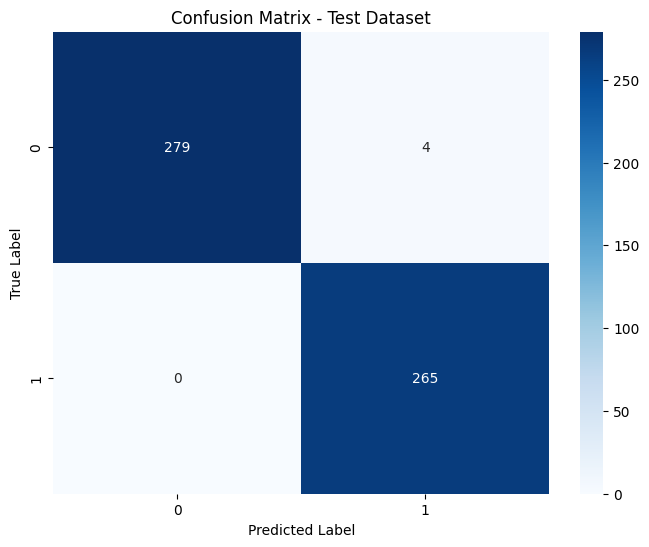

In [91]:
# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\1_test_data\confusion_matrix_downsamples_test.png')
plt.show()
plt.close()

<font size='6'>Model Validation using External Dataset</font>

<font size='5'>Load & Pre-process Dataset</font>

In [92]:
val_df = pd.read_csv(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\1_data\validation_dataset.csv')
val_text = val_df['text']
val_labels = val_df['spam']

<font size='5'>Preprocess text using the same clean_data function</font>

In [93]:
val_processed = [clean_data(text) for text in val_text]

<font size='5'>Convert processed text back to strings for prediction</font>

In [94]:
val_processed_str = [' '.join(tokens) for tokens in val_processed]

<font size='5'>Make predictions</font>

In [95]:
val_pred = pipe.predict(val_processed_str)

<font size='5'>Model validating</font>

In [96]:
# Classification report and the confusion matrix
print("Classification Report:\n", classification_report(val_labels, val_pred))
print("\n")
print("Confusion Matrix:\n", confusion_matrix(val_labels, val_pred))

# Save results
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\classification_report_downsampled_val.txt', 'w') as f:
    f.write(classification_report(val_labels, val_pred))
np.savetxt(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\confusion_matrix_downsampled_val.txt', confusion_matrix(val_labels, val_pred), fmt='%d')

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



Confusion Matrix:
 [[5 0]
 [0 5]]


<font size='5'>Model Accuracy</font>

In [100]:
v_accuracy = metrics.accuracy_score(val_labels, val_pred)
v_precision = metrics.precision_score(val_labels, val_pred)
v_recall = metrics.recall_score(val_labels, val_pred)
v_f1 = metrics.f1_score(val_labels, val_pred)

print("Test Metrics:")
print(f"Accuracy: {v_accuracy}")
print(f"Precision: {v_precision}")
print(f"Recall: {v_recall}")
print(f"F1-Score: {v_f1}")

# Save metrics
with open(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\metrics_downsampled_val.txt', 'w') as f:
    f.write(f"Accuracy: {v_accuracy}\n")
    f.write(f"Precision: {v_precision}\n")
    f.write(f"Recall: {v_recall}\n")
    f.write(f"F1-Score: {v_f1}\n")

Test Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


<font size='5'>Visualize confusion matrix</font>

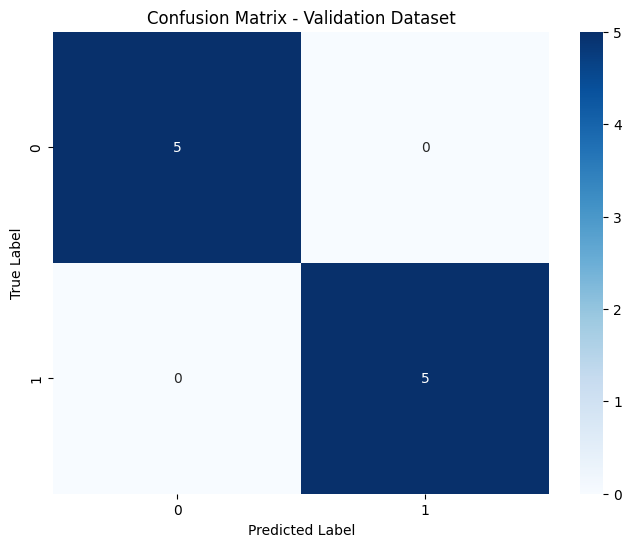

In [97]:
cm = confusion_matrix(val_labels, val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(r'D:\Z1. Data Science Career\2. Python\Infotech\2025.07.30 - Project 2\Project_02_Spam_Email_Classifier_Infotech\4_visualizations\2_validation_data\confusion_matrix_downsamples_val.png')
plt.show()
plt.close()